## Import Library

In [1]:
import numpy as np # linear algebra 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv) 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 
plt.style.use('fivethirtyeight')

## Import Data and do preprocessing
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region.

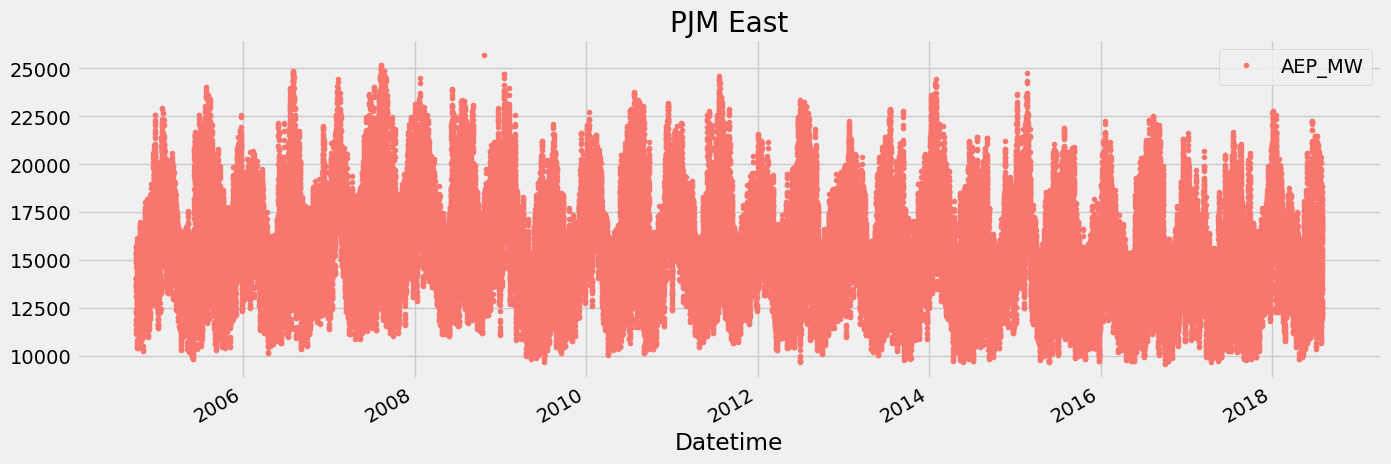

In [2]:
pjme = pd.read_csv('D:/[DOC]/MASH_/20250206/AEP_hourly.csv', index_col=[0], parse_dates=[0])
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

In [3]:
pjme.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


## Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [4]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

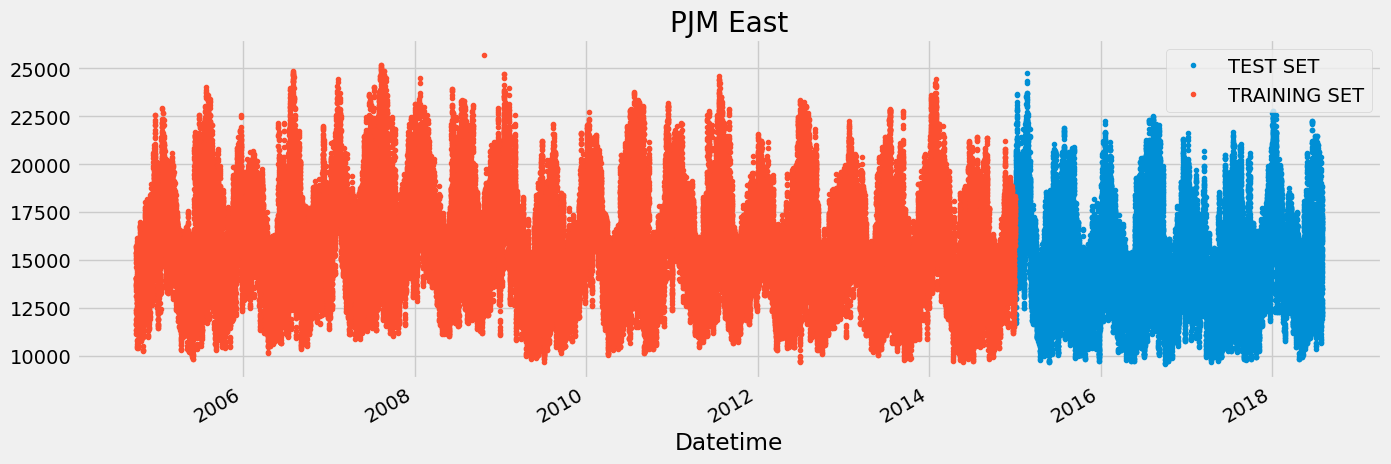

In [5]:
_ = pjme_test.rename(columns={'AEP_MW': 'TEST SET'}).join(pjme_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='PJM East', style='.')

## Create Time Series Features

In [6]:
# X 为所有可用时间解释的变量(feature)；可只考虑较重要的特征维度，或采用降维后特征
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
##    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(pjme_train, label='AEP_MW')
X_test, y_test = create_features(pjme_test, label='AEP_MW')

In [8]:
reg = RandomForestRegressor(n_estimators=1000, max_depth=3, random_state=42)  # max_depth is to prevent overfitting
reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=1000, random_state=42)

## Forecast on Test Set

In [9]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

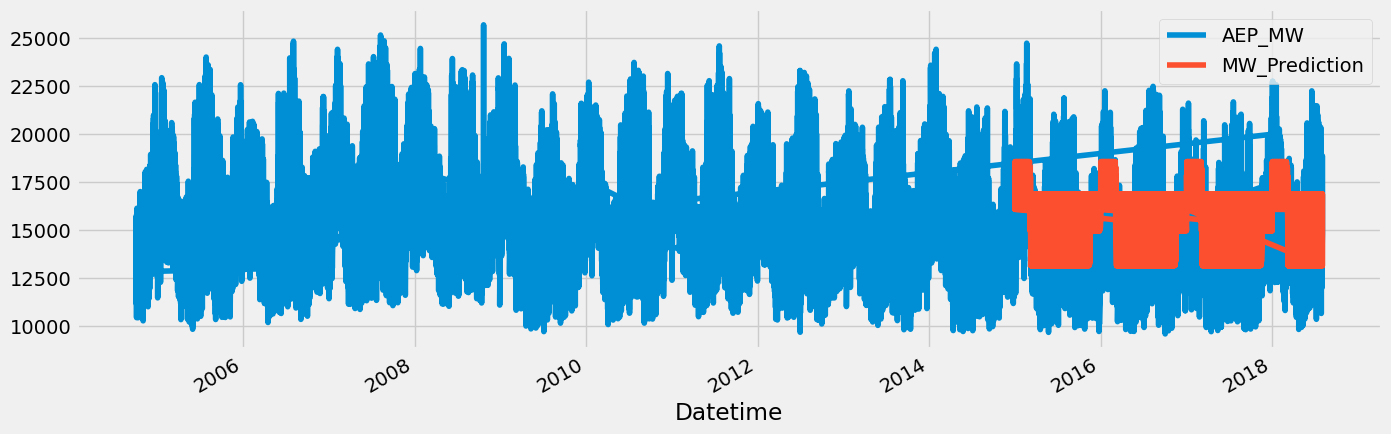

In [10]:
_ = pjme_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

## Look at first month of predictions

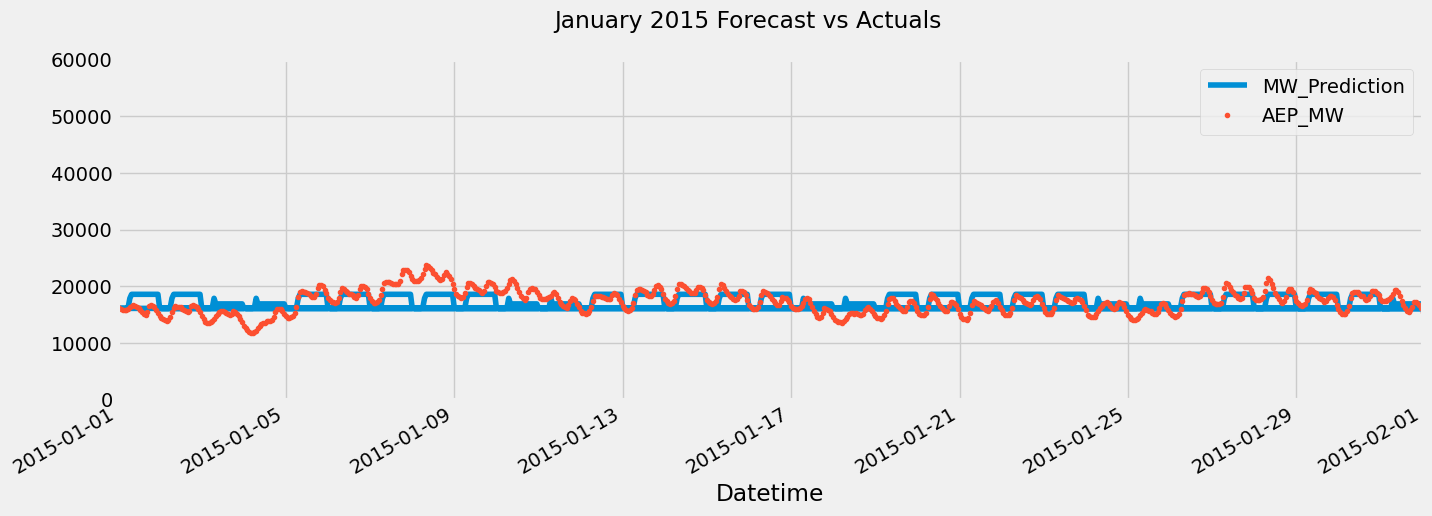

In [11]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

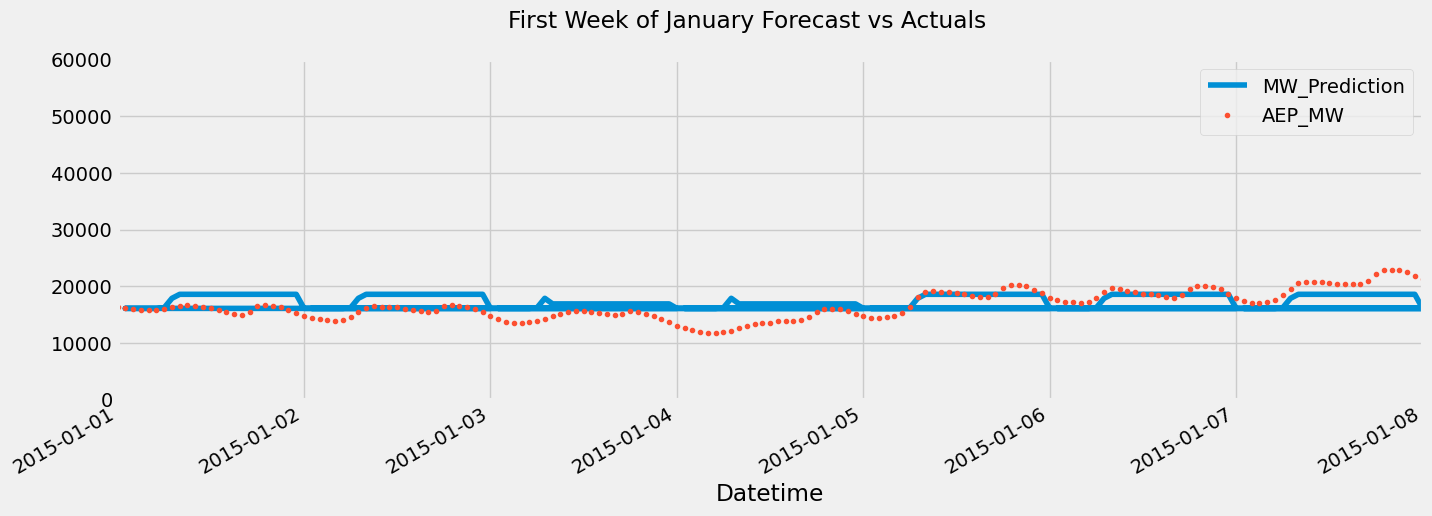

In [12]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

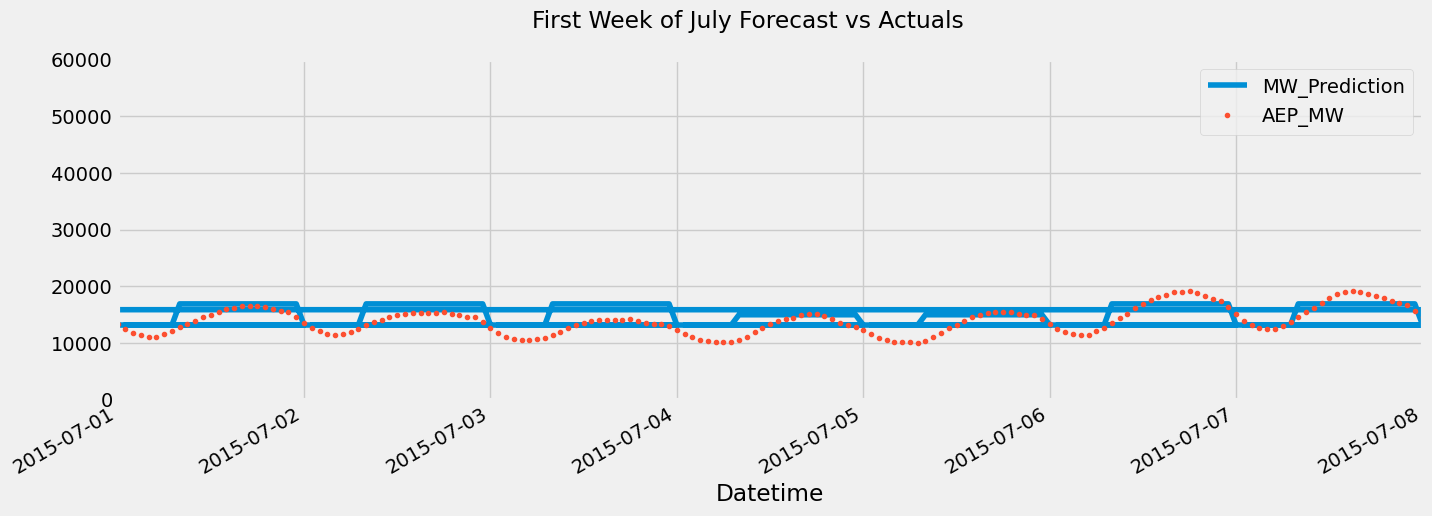

In [13]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

## Error Metrics On Test Set
Our RMSE error is ?

Our MAE error is ?

Our MAPE error is ?

In [14]:
mean_squared_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

4785351.661817717

In [15]:
mean_absolute_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

1852.7785301794718

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
mean_absolute_percentage_error(y_true=pjme_test['AEP_MW'], y_pred=pjme_test['MW_Prediction'])

13.0884723628953

## Look at Worst and Best Predicted Days

In [18]:
pjme_test['error'] = pjme_test['AEP_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']).mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [19]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    25          11078.041667   16296.717753 -5218.676086  5218.676086
           24          11466.041667   16296.717753 -4830.676086  4830.676086
2017 2     24          13111.625000   17814.391031 -4702.766031  4702.766031
2015 11    26          11718.500000   16240.876857 -4522.376857  4522.376857
2017 2     19          12189.541667   16687.326385 -4497.784718  4497.784718
2015 11    27          11755.083333   16245.264093 -4490.180759  4490.180759
2017 1     22          12295.541667   16687.326385 -4391.784718  4391.784718
     2     23          13437.333333   17814.391031 -4377.057698  4377.057698
2018 2     25          12331.875000   16687.326385 -4355.451385  4355.451385
2017 1     2           13478.583333   17814.391031 -4335.807698  4335.807698

Notice anything about the over forecasted days?

<li> worst day - July 4th, 2016 - is a holiday. </li>
<li> worst day - December 25, 2015 - Christmas. </li>
<li> worst day - July 4th, 2016 - is a holiday. </li>
Looks like our model may benefit from adding a holiday indicator.

In [20]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    25          11078.041667   16296.717753 -5218.676086  5218.676086
           24          11466.041667   16296.717753 -4830.676086  4830.676086
2017 2     24          13111.625000   17814.391031 -4702.766031  4702.766031
2015 11    26          11718.500000   16240.876857 -4522.376857  4522.376857
2017 2     19          12189.541667   16687.326385 -4497.784718  4497.784718
2015 11    27          11755.083333   16245.264093 -4490.180759  4490.180759
     2     19          22249.500000   17814.391031  4435.108969  4435.108969
2017 1     22          12295.541667   16687.326385 -4391.784718  4391.784718
     2     23          13437.333333   17814.391031 -4377.057698  4377.057698
2018 2     25          12331.875000   16687.326385 -4355.451385  4355.451385

The best predicted days seem to be a lot of Dec. (not many holidays and mild weather) Also early may

In [21]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2018 4     7           14300.083333   14349.393006  -49.309673  335.931585
2015 3     1           16580.708333   16687.326385 -106.618052  380.157763
2017 1     5           18105.375000   17814.391031  290.983969  385.246673
2018 2     7           17425.625000   17814.391031 -388.766031  434.235634
2016 4     9           14383.416667   14349.393006   34.023660  442.331298
     12    31          14979.375000   15016.848790  -37.473790  448.856963
     2     9           18011.916667   17814.391031  197.525635  463.311367
2018 1     30          17995.375000   17814.391031  180.983969  491.643405
2016 12    13          16492.708333   16296.717753  195.990581  500.213891
2015 1     30          17641.958333   17814.391031 -172.432698  503.415722

Plotting some best/worst predicted days

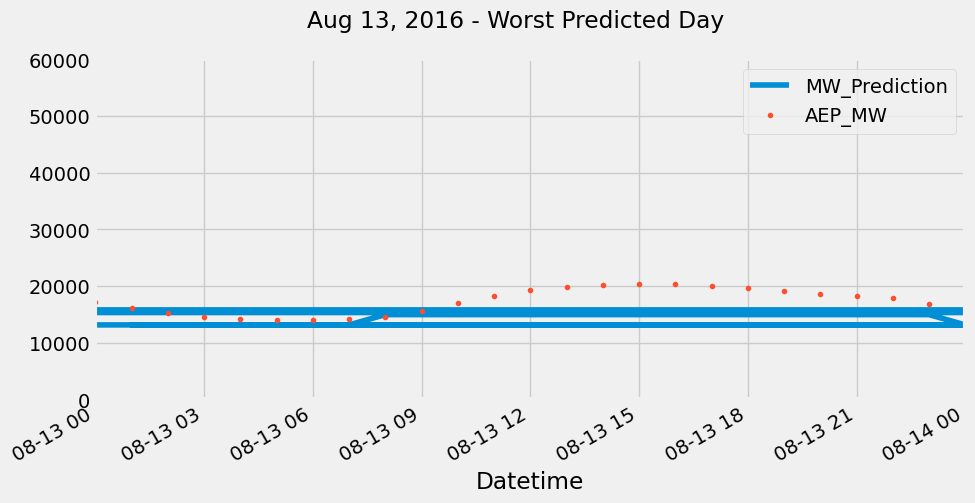

In [22]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

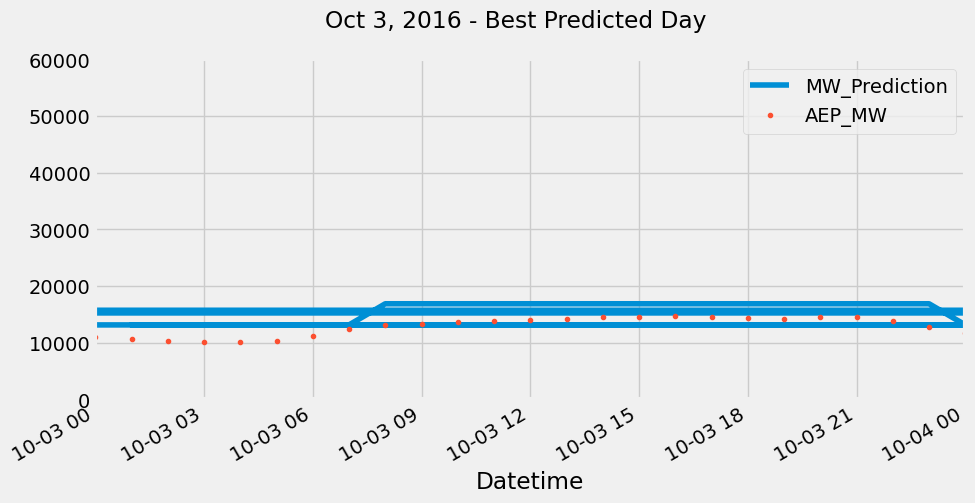

In [23]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

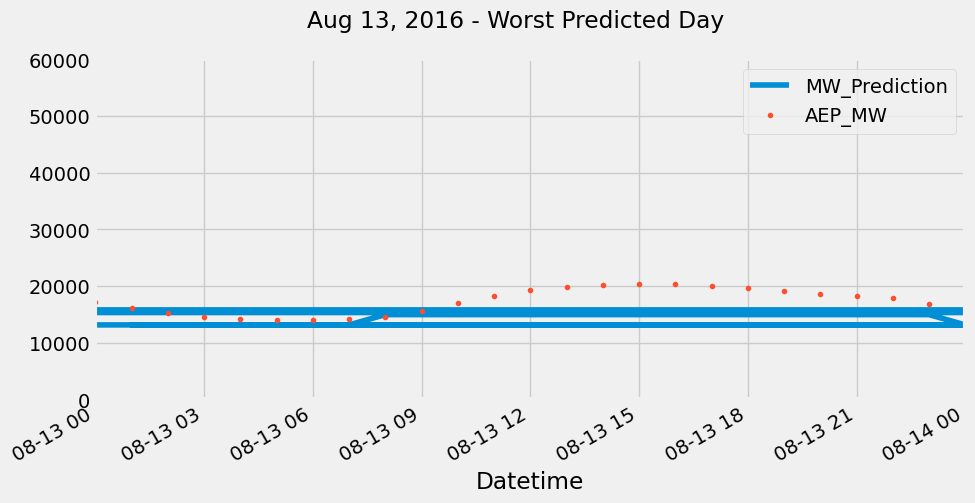

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','AEP_MW']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

## Up next?
<li>Add Lag variables.</li>
<li>Add holiday indicators.</li>
<li>Add weather data source.</li>
<li>Add other data source empirically correlated to time.</li>